# 信用评分卡建模

本文将针对 Kaggle 数据 [Give me some credit](https://www.kaggle.com/c/GiveMeSomeCredit/data)构建一个信用评分卡模型。本文主要分为载入数据、数据的探索与分析、数据预处理、特征工程、定义评价指标、模型构建、制作评分卡等部分。(由于所给测试集SeriousDlqin2yrs字段全为空，所以无法做模型评估)

## 1. 加载库并读入数据

### 1.1 加载库

In [163]:
# -*- coding: utf-8 -*-
#!/usr/bin/env python

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve
from __future__ import division
import warnings

# 忽略告警
warnings.filterwarnings('ignore')

### 1.2 读入数据

In [8]:
data_train = pd.read_csv('./data/cs-training.csv')

## 2. 数据探索与分析

### 2.1 变量分布和描述

In [9]:
data_train.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,75000.500000,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,43301.414527,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


了解各列名的含义：
- SeriousDlqin2yrs：超过90天或更糟的逾期拖欠
- RevolvingUtilizationOfUnsecuredLines：除了房贷车贷之外的信用卡账面金额（即贷款金额）/信用卡总额度
- age：贷款人年龄
- NumberOfTime30-59DaysPastDueNotWorse：35-59天逾期但不糟糕次数
- DebtRatio：负债比率
- MonthlyIncome：月收入
- NumberOfOpenCreditLinesAndLoans：开放式信贷和贷款数量，开放式贷款（分期付款如汽车贷款或抵押贷款）和信贷（如信用卡）的数量
- NumberOfTimes90DaysLate：借款者有90天或更高逾期的次数
- NumberRealEstateLoansOrLines：不动产贷款或额度数量
- NumberOfTime60-89DaysPastDueNotWorse：60-89天逾期但不糟糕次数
- NumberOfDependents：不包括本人在内的家属数量

In [11]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
Unnamed: 0                              150000 non-null int64
SeriousDlqin2yrs                        150000 non-null int64
RevolvingUtilizationOfUnsecuredLines    150000 non-null float64
age                                     150000 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    150000 non-null int64
DebtRatio                               150000 non-null float64
MonthlyIncome                           120269 non-null float64
NumberOfOpenCreditLinesAndLoans         150000 non-null int64
NumberOfTimes90DaysLate                 150000 non-null int64
NumberRealEstateLoansOrLines            150000 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    150000 non-null int64
NumberOfDependents                      146076 non-null float64
dtypes: float64(4), int64(8)
memory usage: 13.7 MB


从以上信息可以看出：
- RevolvingUtilizationOfUnsecuredLines的正常取值应在0-1之间，而其最大值为50708，很有可能含有异常值
- age最小值为0，最大值为109，也很可能含有异常值
- MonthlyIncome只有120269条记录，NumberOfDependents只有146076条记录，说明有缺失值

### 2.2 初步清洗

In [14]:
#选择子集
data_train.drop('Unnamed: 0',axis=1,inplace=True)
data_train.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [17]:
#列名重命名
colnames={'SeriousDlqin2yrs':'Isdlq',
         'RevolvingUtilizationOfUnsecuredLines':'Revol',
         'NumberOfTime30-59DaysPastDueNotWorse':'Num30-59late',
         'NumberOfOpenCreditLinesAndLoans':'Numopen',
         'NumberOfTimes90DaysLate':'Num90late',
         'NumberRealEstateLoansOrLines':'Numestate',
         'NumberOfTime60-89DaysPastDueNotWorse':'Num60-89late',
         'NumberOfDependents':'Numdepend'}
data_train.rename(columns=colnames,inplace=True)
data_train.head()

,Isdlq,Revol,age,Num30-59late,DebtRatio,MonthlyIncome,Numopen,Num90late,Numestate,Num60-89late,Numdepend
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


### 2.3 各变量分析

先看总体情况，然后对各变量逐一分析：

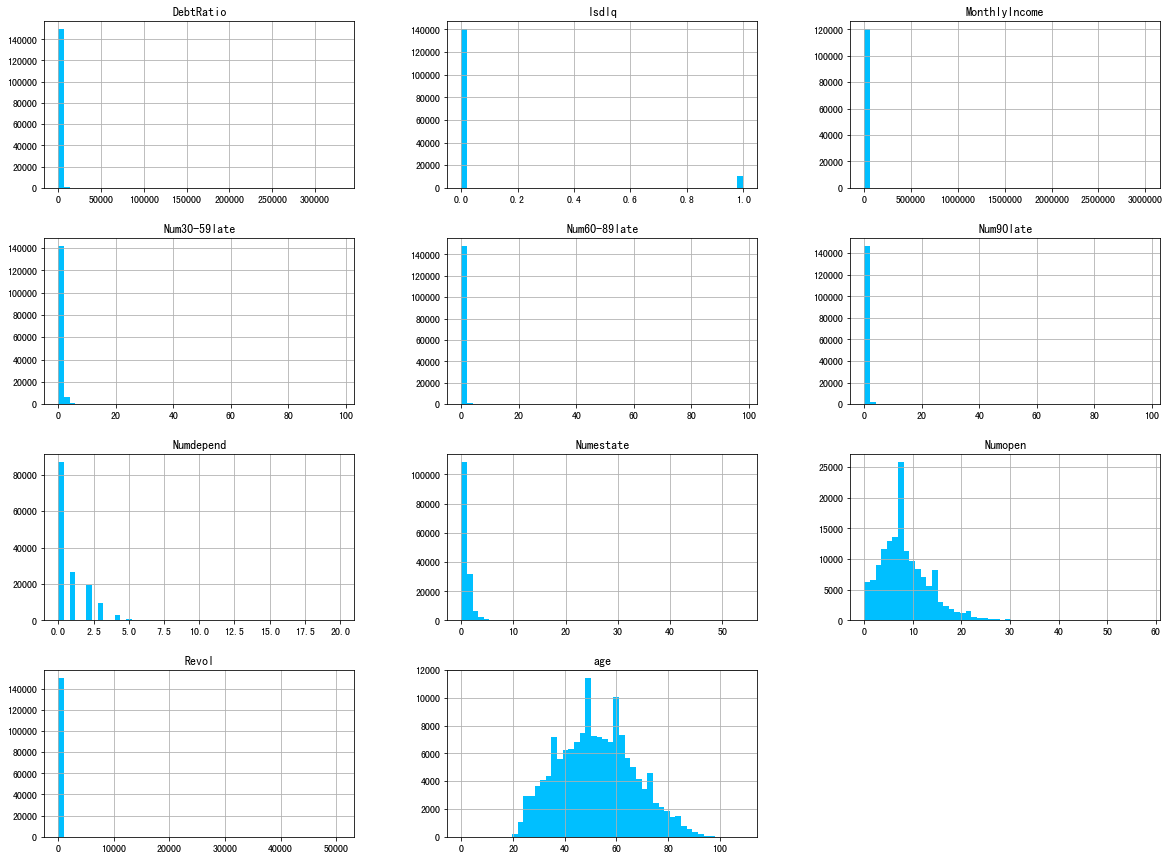

In [18]:
data_train.hist (bins=50, figsize=(20,15), color = 'deepskyblue')

plt.show()

- **Isdlq**

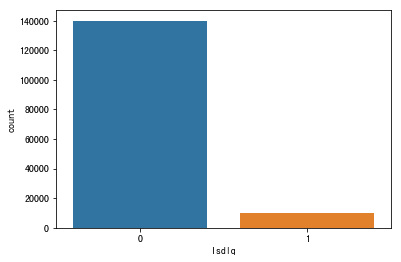

In [19]:
sns.countplot('Isdlq',data=data_train)

In [26]:
badNum=data_train.loc[data_train['Isdlq']==1,:].shape[0]
goodNum=data_train.loc[data_train['Isdlq']==0,:].shape[0]
print('The rate of SeriousDlqin2yrs=1: {0}%'.format(round(badNum*100/(goodNum+badNum),2)))

The rate of SeriousDlqin2yrs=1: 6.0%


数据不平衡，逾期拖欠发生数量占总数的6.0%，后期需处理。

- **Age**

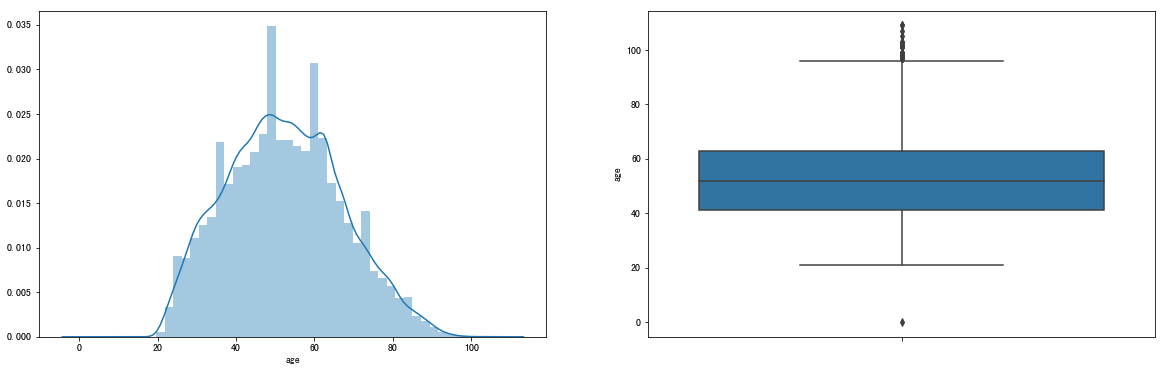

In [21]:
#Age数据分布情况
fig,[ax1,ax2]=plt.subplots(1,2,figsize=(20,6))
sns.distplot(data_train['age'],ax=ax1)
sns.boxplot(y='age',data=data_train,ax=ax2)

可看出年龄分布基本符合正太分布，但存在异常值。用3倍标准差来筛选异常值。

In [33]:
#异常值情况
age_mean=data_train['age'].mean()
age_std=data_train['age'].std()
age_lowlimit=age_mean-3*age_std
age_uplimit=age_mean+3*age_std
print('age_lowlimit:',age_lowlimit,'age_uplimit:',age_uplimit)

('age_lowlimit:', 7.979609077365616, 'age_uplimit:', 96.61080425596771)


In [36]:
#筛选异常值
age_lowlimitd=data_train.loc[data_train['age']<age_lowlimit,:]
age_uplimitd=data_train.loc[data_train['age']>age_uplimit,:]
print('The rate of age_lowlimit: {0}%'.format(age_lowlimitd.shape[0]*100/data_train.shape[0]),
     'The rate of age_uplimit: {0}%'.format(age_uplimitd.shape[0]*100/data_train.shape[0]))

('The rate of age_lowlimit: 0.000666666666667%', 'The rate of age_uplimit: 0.03%')


年龄为0的应删除，超过96岁的可判断为噪声。再看下各年龄段违约率情况：

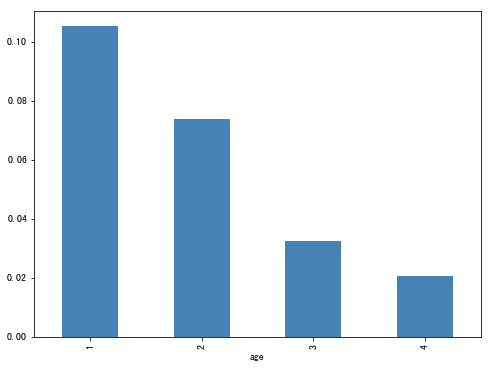

In [37]:
data_age=data_train.loc[data_train['age']>0,['age','Isdlq']]
data_age.loc[(data_age['age']>18)&(data_age['age']<40),'age'] = 1
data_age.loc[(data_age['age']>=40)&(data_age['age']<60),'age'] = 2 
data_age.loc[(data_age['age']>=60)&(data_age['age']<80),'age'] = 3
data_age.loc[(data_age['age']>=80),'age'] = 4
age_Isdlq=data_age.groupby('age')['Isdlq'].sum()
age_total=data_age.groupby('age')['Isdlq'].count()
age_Isratio=age_Isdlq/age_total
age_Isratio.plot(kind='bar',figsize=(8,6),color='#4682B4')

可看出18-40岁违约率最高，随年岁增长，违约率降低。

- **Revol**

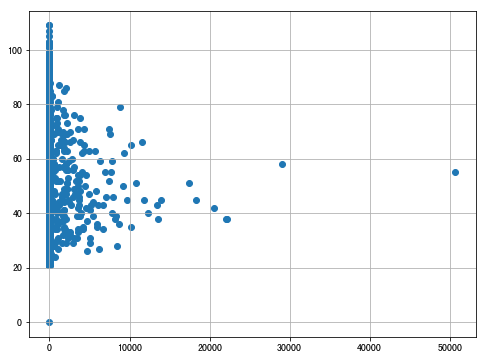

In [39]:
#Revol数据分布
figure=plt.figure(figsize=(8,6))
plt.scatter(data_train['Revol'],data_train['age'])
plt.grid()

Revol的正常取值在0-1之间，超出1的为透支，但有些超过10000的数据应为异常值。把数据分为两部分，小于1的部分和大于1的部分，看看这两部分的数据分布情况。

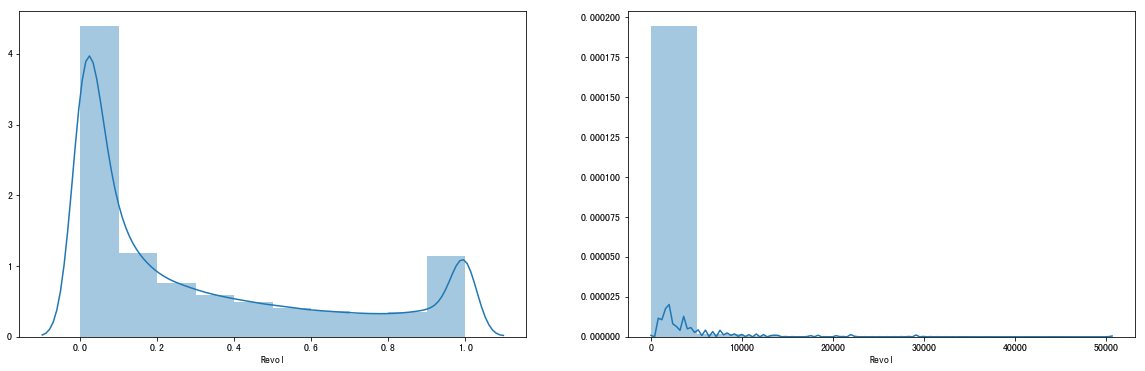

In [40]:
#将数据分为两部分，小于1和大于1的部分
data1=data_train.loc[data_train['Revol']<1,:]
data2=data_train.loc[data_train['Revol']>=1,:]
#看一下两部分数据分布情况
fig=plt.figure(figsize=(20,6))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
sns.distplot(data1['Revol'],ax=ax1,bins=10)
sns.distplot(data2['Revol'],ax=ax2,bins=10)

由第二个图可看出大于1的数据大部分在0-10000之间。把区间0-10000进一步细分为[1，100, [100，1000), [1000，10000), 10000以上，分别查看数据的分布情况。

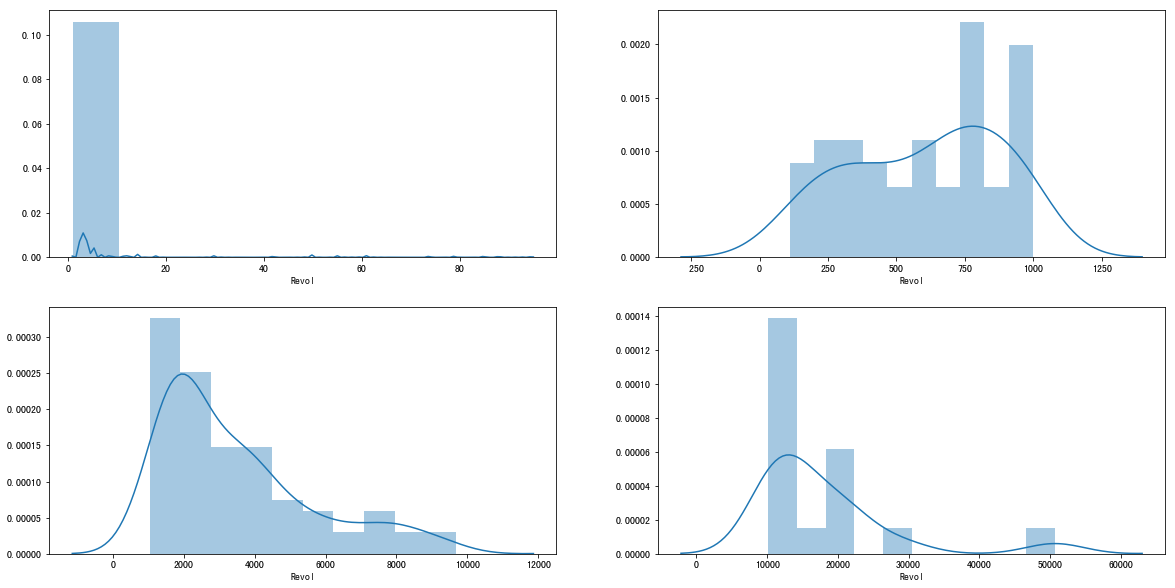

In [41]:
fig,[[ax1,ax2],[ax3,ax4]]=plt.subplots(2,2,figsize=(20,10))
sns.distplot(data_train.loc[(data_train['Revol']>=1)&(data_train['Revol']<100),'Revol'],bins=10,ax=ax1)
sns.distplot(data_train.loc[(data_train['Revol']>=100)&(data_train['Revol']<1000),'Revol'],bins=10,ax=ax2)
sns.distplot(data_train.loc[(data_train['Revol']>=1000)&(data_train['Revol']<10000),'Revol'],bins=10,ax=ax3)
sns.distplot(data_train.loc[data_train['Revol']>=10000,'Revol'],bins=10,ax=ax4)

可见大于1的数据绝大多数数据集中在1-20之间，我们的目的是找到异常值的阈值，我们分区间，分别看一下违约率情况。

In [42]:
#将区间分为（0-1），(1-10),（10-20），（20-100），（100,1000），（1000-10000），（10000,51000）看一下违约率情况
data_1=data_train.loc[(data_train['Revol']>=0)&(data_train['Revol']<1),:]
Is_1=data_1.loc[data_1['Isdlq']==1,:].shape[0]*100/data_1.shape[0]

data_2=data_train.loc[(data_train['Revol']>=1)&(data_train['Revol']<10),:]
Is_2=data_2.loc[data_2['Isdlq']==1,:].shape[0]*100/data_2.shape[0]

data_3=data_train.loc[(data_train['Revol']>=10)&(data_train['Revol']<20),:]
Is_3=data_3.loc[data_3['Isdlq']==1,:].shape[0]*100/data_3.shape[0]

data_4=data_train.loc[(data_train['Revol']>=20)&(data_train['Revol']<100),:]
Is_4=data_4.loc[data_4['Isdlq']==1,:].shape[0]*100/data_4.shape[0]

data_5=data_train.loc[(data_train['Revol']>=100)&(data_train['Revol']<1000),:]
Is_5=data_5.loc[data_5['Isdlq']==1,:].shape[0]*100/data_5.shape[0]

data_6=data_train.loc[(data_train['Revol']>=1000)&(data_train['Revol']<10000),:]
Is_6=data_6.loc[data_6['Isdlq']==1,:].shape[0]*100/data_6.shape[0]

data_7=data_train.loc[(data_train['Revol']>=10000)&(data_train['Revol']<51000),:]
Is_7=data_7.loc[data_7['Isdlq']==1,:].shape[0]*100/data_7.shape[0]

print('0-1: {0}%'.format(Is_1),
     '1-10: {0}%'.format(Is_2),
     '10-20: {0}%'.format(Is_3), 
     '20-100: {0}%'.format(Is_4),
     '100-1000: {0}%'.format(Is_5),
     '1000-10000: {0}%'.format(Is_6),
     '10000-51000: {0}%'.format(Is_7))

('0-1: 5.98996331701%', '1-10: 39.5221181789%', '10-20: 57.1428571429%', '20-100: 18.1818181818%', '100-1000: 1.96078431373%', '1000-10000: 6.41025641026%', '10000-51000: 0.0%')


可以看出在Revol大于1时，违约率开始上升，10-20之间违约率达到高峰，超过20后开始下降，超过1000后开始恢复正常。说明20左右的值可能为异常值上限的阈值。可将超过20的值都定义为异常值。

- **DebtRatio**

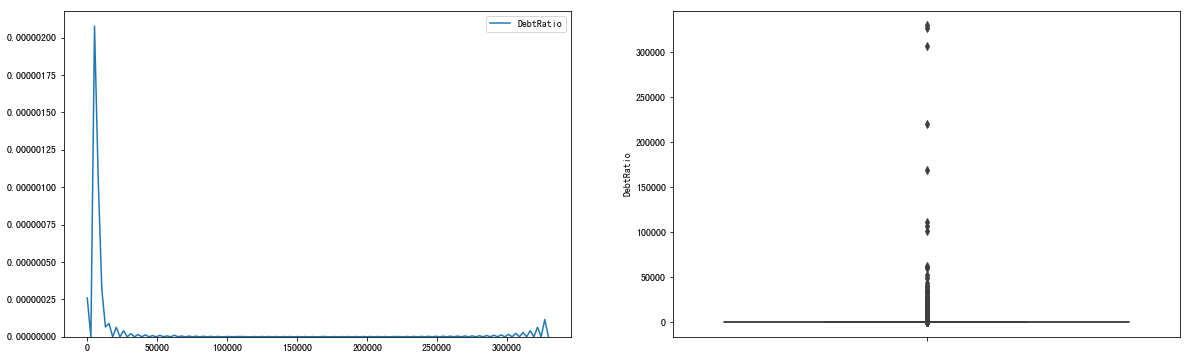

In [44]:
#DebtRatio数据的分布情况
fig,[ax1,ax2]=plt.subplots(1,2,figsize=(20,6))
sns.kdeplot(data_train['DebtRatio'],ax=ax1)
sns.boxplot(y=data_train['DebtRatio'],ax=ax2)

数据分布跨度较大，先分组查看数据的分布情况：

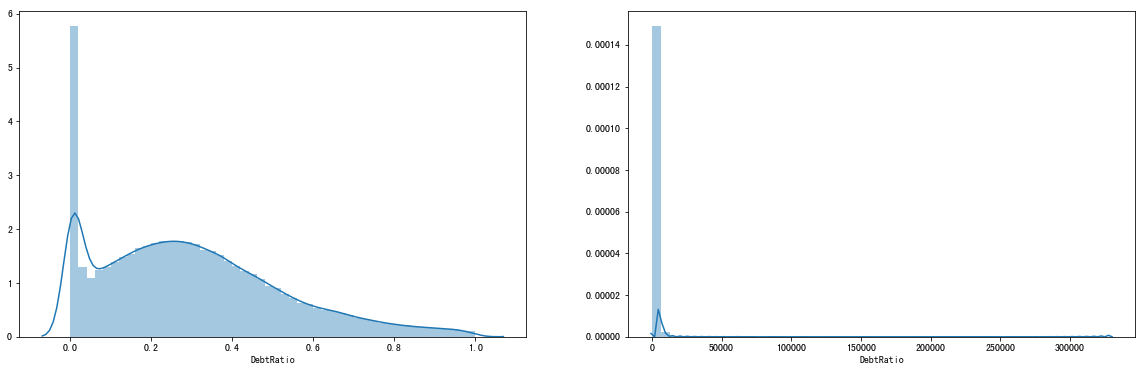

In [45]:
Debt1=data_train.loc[data_train['DebtRatio']<1,:]
Debt2=data_train.loc[data_train['DebtRatio']>=1,:]
fig,[ax1,ax2]=plt.subplots(1,2,figsize=(20,6))
sns.distplot(Debt1['DebtRatio'],ax=ax1)
sns.distplot(Debt2['DebtRatio'],ax=ax2)

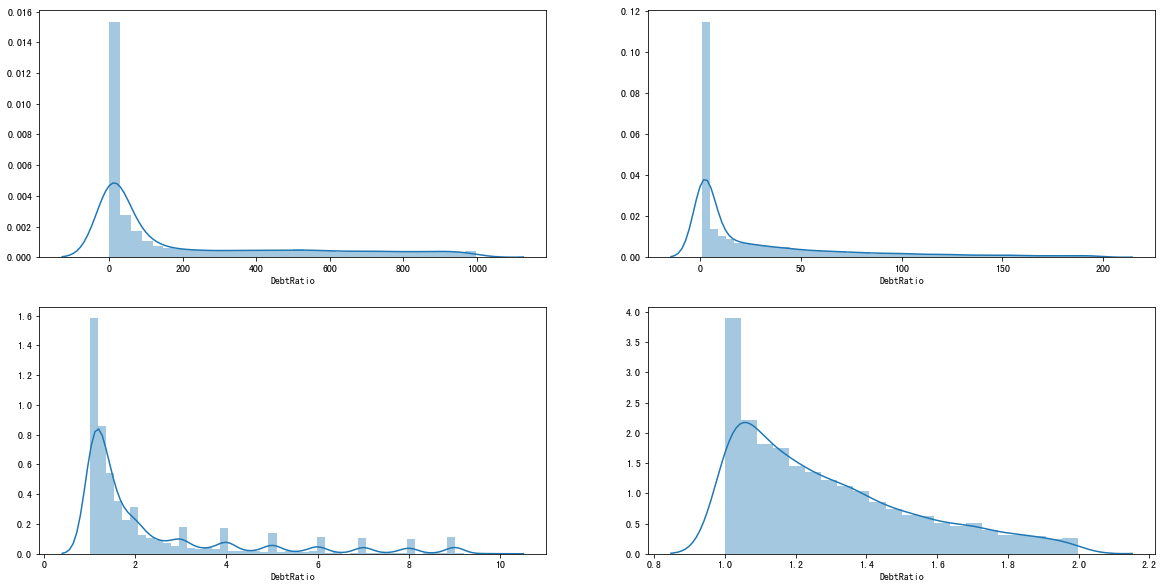

In [46]:
#尝试多次细分
Debt3=data_train.loc[(data_train['DebtRatio']>=1)&(data_train['DebtRatio']<1000),:]
Debt4=data_train.loc[(data_train['DebtRatio']>=1)&(data_train['DebtRatio']<200),:]
Debt5=data_train.loc[(data_train['DebtRatio']>=1)&(data_train['DebtRatio']<10),:]
Debt6=data_train.loc[(data_train['DebtRatio']>=1)&(data_train['DebtRatio']<2),:]

fig,[[ax1,ax2],[ax3,ax4]]=plt.subplots(2,2,figsize=(20,10))
sns.distplot(Debt3['DebtRatio'],ax=ax1)
sns.distplot(Debt4['DebtRatio'],ax=ax2)
sns.distplot(Debt5['DebtRatio'],ax=ax3)
sns.distplot(Debt6['DebtRatio'],ax=ax4)

查看各区间的违约情况：

In [48]:
#各区间的违约率(0,1),(1-2),(2-10),(10-50),(50-200),(200,1000),1000以上
Debt_1=data_train.loc[(data_train['DebtRatio']>=0)&(data_train['DebtRatio']<1),:]
DebIs_1=Debt_1.loc[Debt_1['Isdlq']==1,:].shape[0]*100/Debt_1.shape[0]

Debt_2=data_train.loc[(data_train['DebtRatio']>=1)&(data_train['DebtRatio']<2),:]
DebIs_2=Debt_2.loc[Debt_2['Isdlq']==1,:].shape[0]*100/Debt_2.shape[0]

Debt_3=data_train.loc[(data_train['DebtRatio']>=2)&(data_train['DebtRatio']<10),:]
DebIs_3=Debt_3.loc[Debt_3['Isdlq']==1,:].shape[0]*100/Debt_3.shape[0]

Debt_4=data_train.loc[(data_train['DebtRatio']>=10)&(data_train['DebtRatio']<50),:]
DebIs_4=Debt_4.loc[Debt_4['Isdlq']==1,:].shape[0]*100/Debt_4.shape[0]

Debt_5=data_train.loc[(data_train['DebtRatio']>=50)&(data_train['DebtRatio']<200),:]
DebIs_5=Debt_5.loc[Debt_5['Isdlq']==1,:].shape[0]*100/Debt_5.shape[0]

Debt_6=data_train.loc[(data_train['DebtRatio']>=200)&(data_train['DebtRatio']<1000),:]
DebIs_6=Debt_6.loc[Debt_6['Isdlq']==1,:].shape[0]*100/Debt_6.shape[0]

Debt_7=data_train.loc[data_train['DebtRatio']>=1000,:]
DebIs_7=Debt_7.loc[Debt_7['Isdlq']==1,:].shape[0]*100/Debt_7.shape[0]

print('0-1: {0}%'.format(DebIs_1),
     '1-2: {0}%'.format(DebIs_2),
     '2-10: {0}%'.format(DebIs_3), 
     '10-50: {0}%'.format(DebIs_4),
     '50-200: {0}%'.format(DebIs_5),
     '200-1000: {0}%'.format(DebIs_6),
     '1000: {0}%'.format(DebIs_7))

('0-1: 6.74494478078%', '1-2: 13.0089135148%', '2-10: 6.25844214318%', '10-50: 4.34638354346%', '50-200: 5.6269538034%', '200-1000: 7.95033059184%', '1000: 4.90532544379%')


可看到1-2的违约率达到最高，超过2以后违约率开始稳定。这里把2作为异常值上限的阈值。并把大于2的数据和0-1的数据进行合并。

- **Numopen**

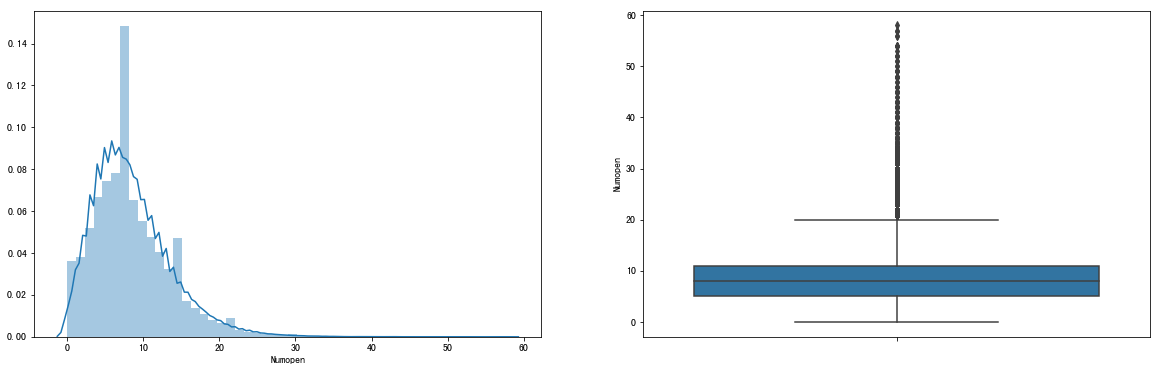

In [50]:
#数据分布
fig,[ax1,ax2]=plt.subplots(1,2,figsize=(20,6))
sns.distplot(data_train['Numopen'],ax=ax1)
sns.boxplot(y=data_train['Numopen'],ax=ax2)

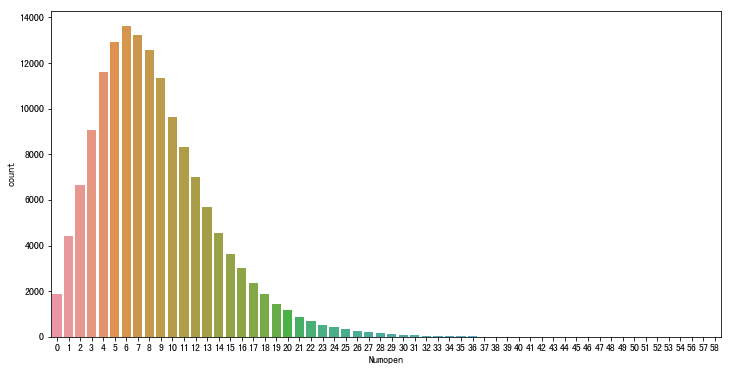

In [51]:
#查看数据点分布
figure=plt.figure(figsize=(12,6))
sns.countplot(data_train['Numopen'])

可以看出大于36的数据过少，我们把大于36的数据和36合并，并查看违约率情况。

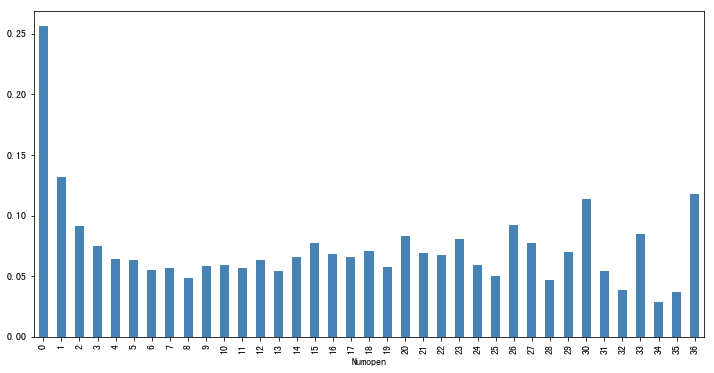

In [53]:
data_train.loc[data_train['Numopen']>36,'Numopen']=36
Numopen_dlq=data_train.groupby(['Numopen'])['Isdlq'].sum()
Numopen_total=data_train.groupby(['Numopen'])['Isdlq'].count()
Numopen_dlqratio=Numopen_dlq/Numopen_total
Numopen_dlqratio.plot(kind='bar',figsize=(12,6),color='#4682B4')


- **Numestate**

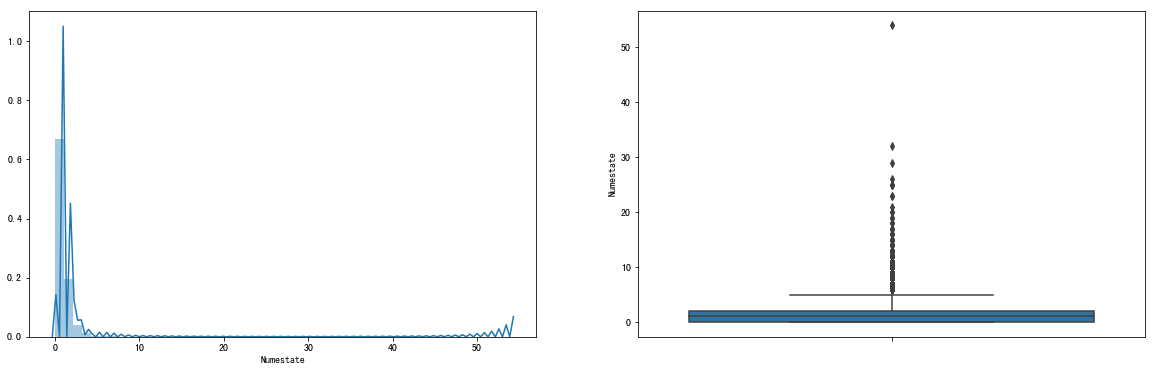

In [55]:
#数据分布
fig,[ax1,ax2]=plt.subplots(1,2,figsize=(20,6))
sns.distplot(data_train['Numestate'],ax=ax1)
sns.boxplot(y=data_train['Numestate'],ax=ax2)

可看到超过50的点为明显的异常点。

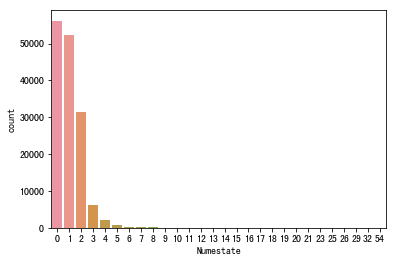

In [56]:
#查看各数据点数据大小分布
sns.countplot(data_train['Numestate'])

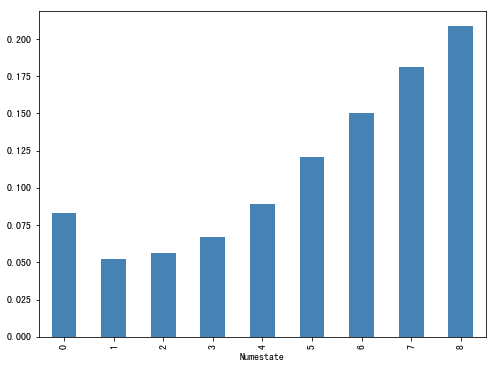

In [57]:
#将大于8的数据和8合并后看一下违约率的情况
data_train.loc[data_train['Numestate']>8,'Numestate']=8
Numestate_dlq=data_train.groupby(['Numestate'])['Isdlq'].sum()
Numestate_total=data_train.groupby(['Numestate'])['Isdlq'].count()
Numestate_dlqratio=Numestate_dlq/Numestate_total
Numestate_dlqratio.plot(kind='bar',figsize=(8,6),color='#4682B4')

从Numopen和Numestate的违约率分布可以看出，贷款数量为0时并不是违约率最低的，不动产贷款数量为1时违约率最低，但随着打款数量增加，违约率也随着增高

- **Numdepend**

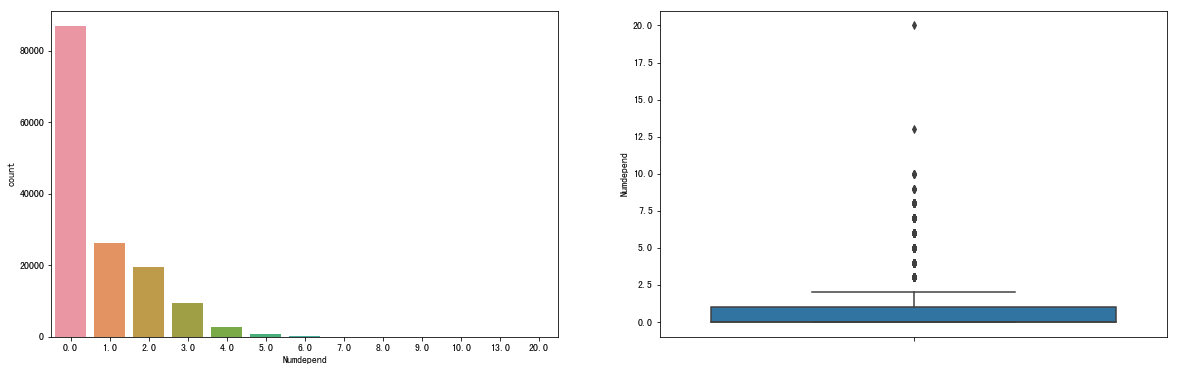

In [58]:
#Numdepend数据分布
fig,[ax1,ax2]=plt.subplots(1,2,figsize=(20,6))
sns.countplot(data_train['Numdepend'],ax=ax1)
sns.boxplot(y=data_train['Numdepend'],ax=ax2)

由2.1节的描述统计信息可知Numdepend中含有缺失值，查看缺失值情况：

In [60]:
D_nullNum=data_train['Numdepend'].isnull().sum()
print('The number of missing value: ',D_nullNum,'The ratio of missing value: {0}%'.format(D_nullNum*100/data_train.shape[0]))

('The number of missing value: ', 3924, 'The ratio of missing value: 2.616%')


In [61]:
#查看MonthlyIncome和Numdepend的缺失是否有关联
data_train.loc[(data_train['Numdepend'].isnull())&(data_train['MonthlyIncome'].isnull()),:].shape[0]

3924

可以看出Numdepend缺失的，MonthlyIncome也同时缺失。所以，接下来看一下MonthlyIncome缺失，Numdepend不缺失的数据分布：

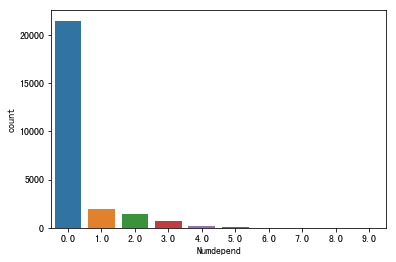

In [62]:
MonthNullDependNot=data_train.loc[(data_train['Numdepend'].notnull())&(data_train['MonthlyIncome']).isnull(),:]
sns.countplot(MonthNullDependNot['Numdepend'])

可看出MonthlyIncome缺失，Numdepend不缺失的数据中Numdepend大多取值0，所以我们将Numdepend的缺失值填充为0。

- **MonthlyIncome**

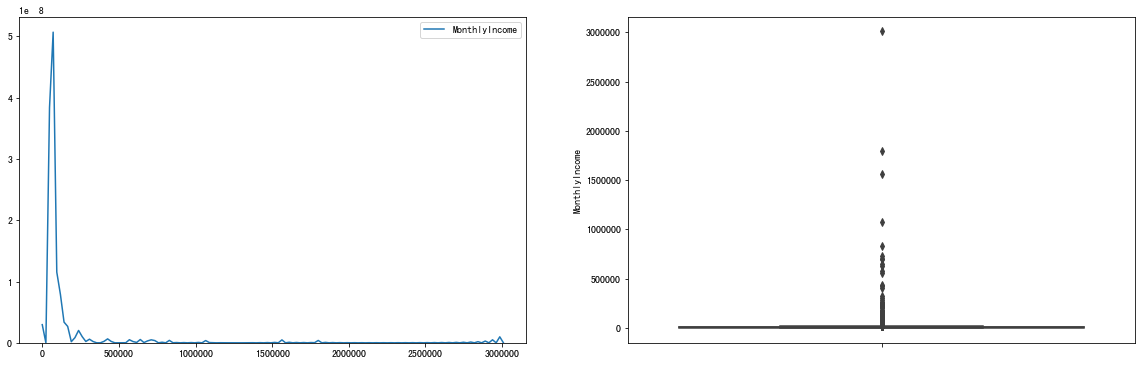

In [65]:
#MonthlyIncome数据分布
fig,[ax1,ax2]=plt.subplots(1,2,figsize=(20,6))
sns.kdeplot(data_train['MonthlyIncome'],ax=ax1)
sns.boxplot(y=data_train['MonthlyIncome'],ax=ax2)

In [67]:
#MonthlyIncome缺失值情况
M_nullNum=data_train['MonthlyIncome'].isnull().sum()
print('The number of missing value: ',M_nullNum,'The ratio of missing value: {0}%'.format(M_nullNum*100/data_train.shape[0]))

('The number of missing value: ', 29731, 'The ratio of missing value: 19.8206666667%')


缺失比例接近20%，不能直接删除，后面采用随机森林填补缺失值。

- **Num30-59late Num60-89late Num90late**

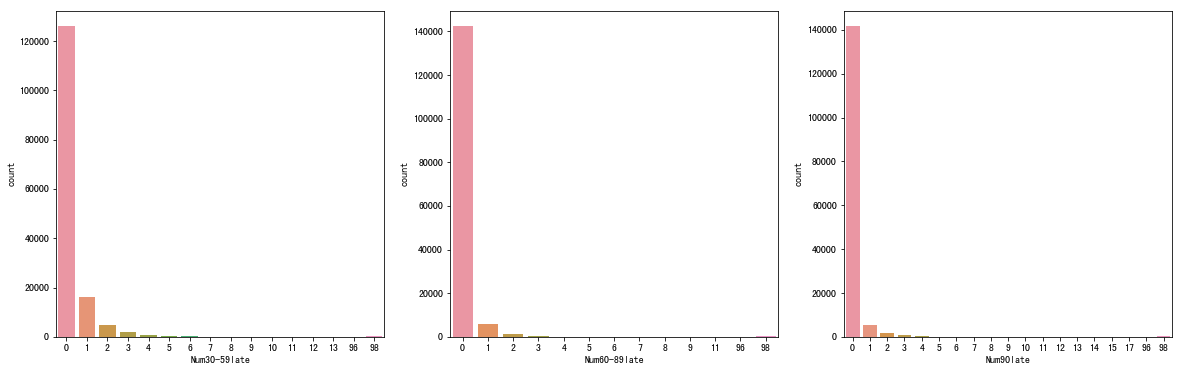

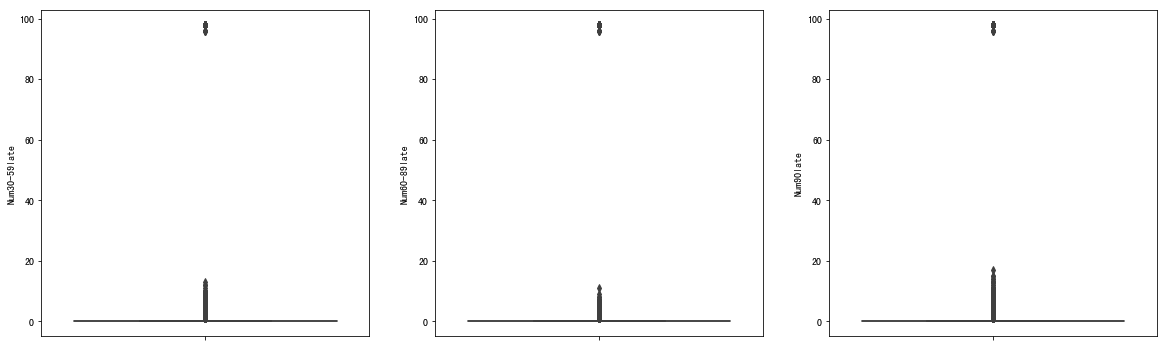

In [72]:
fig,[ax1,ax2,ax3]=plt.subplots(1,3,figsize=(20,6))
sns.countplot(data_train['Num30-59late'],ax=ax1)
sns.countplot(data_train['Num60-89late'],ax=ax2)
sns.countplot(data_train['Num90late'],ax=ax3)

fig,[ax1,ax2,ax3]=plt.subplots(1,3,figsize=(20,6))
sns.boxplot(y=data_train['Num30-59late'],ax=ax1)
sns.boxplot(y=data_train['Num60-89late'],ax=ax2)
sns.boxplot(y=data_train['Num90late'],ax=ax3)

可看出大于90的明显为异常值。

## 3. 数据预处理

### 3.1 异常值处理

In [73]:
#age异常值处理
data_train=data_train[data_train['age']>0]

#Num30-59late Num60-89late Num90late异常值处理
data_train=data_train[data_train['Num30-59late']<90]
data_train=data_train[data_train['Num60-89late']<90]
data_train=data_train[data_train['Num90late']<90]

#Numestate异常值处理
data_train=data_train[data_train['Numestate']<50]

### 3.2 缺失值处理

In [74]:
#Numdepend缺失值处理
data_train['Numdepend']=data_train['Numdepend'].fillna('0')

#MonthlyIncome缺失值处理
#随机森林预测缺失值
data_Forest=data_train.iloc[:,[5,1,2,3,4,6,7,8,9]]
MonthlyIncome_isnull=data_Forest.loc[data_train['MonthlyIncome'].isnull(),:]
MonthlyIncome_notnull=data_Forest.loc[data_train['MonthlyIncome'].notnull(),:]

from sklearn.ensemble import RandomForestRegressor
X=MonthlyIncome_notnull.iloc[:,1:].values
y=MonthlyIncome_notnull.iloc[:,0].values
regr=RandomForestRegressor(max_depth=3, random_state=0,n_estimators=200,n_jobs=-1)
regr.fit(X,y)
MonthlyIncome_fillvalue=regr.predict(MonthlyIncome_isnull.iloc[:,1:].values).round(0)

#填充MonthlyIncome缺失值
data_train.loc[data_train['MonthlyIncome'].isnull(),'MonthlyIncome']=MonthlyIncome_fillvalue

## 4. 特征工程

### 4.1 特征提取

In [75]:
#衍生变量
data_train['AllNumlate']=data_train['Num30-59late']+data_train['Num60-89late']+data_train['Num90late']
data_train['Monthlypayment']=data_train['DebtRatio']*data_train['MonthlyIncome']
data_train['Withdepend']=data_train['Numdepend']

### 4.2 特征分箱

In [76]:
#数据类型转换
data_train['Numdepend']=data_train['Numdepend'].astype('int64')
data_train['Withdepend']=data_train['Withdepend'].astype('int64')
data_train['MonthlyIncome']=data_train['MonthlyIncome'].astype('int64')
data_train['Monthlypayment']=data_train['Monthlypayment'].astype('int64')

#Revol分箱
data_train.loc[(data_train['Revol']<1),'Revol']=0
data_train.loc[(data_train['Revol']>1)&(data_train['Revol']<=20),'Revol']=1
data_train.loc[(data_train['Revol']>20),'Revol']=0#根据前文EDA分析，将大于20的数据与0-1的数据合并

#DebtRatio分箱
data_train.loc[(data_train['DebtRatio']<1),'DebtRatio']=0
data_train.loc[(data_train['DebtRatio']>1)&(data_train['DebtRatio']<2),'DebtRatio']=1
data_train.loc[(data_train['DebtRatio']>=2),'DebtRatio']=0

#Num30-59late/Num60-89late/Num90late/Numestate/Numdepend
data_train.loc[(data_train['Num30-59late']>=8), 'Num30-59late'] = 8
data_train.loc[(data_train['Num60-89late']>=7), 'Num60-89late'] = 7
data_train.loc[(data_train['Num90late']>=10), 'Num90late'] = 10
data_train.loc[(data_train['Numestate']>=8), 'Numestate'] = 8
data_train.loc[(data_train['Numdepend']>=7), 'Numdepend'] = 7

#AllNumlate分箱
data_train.loc[(data_train['AllNumlate']>1),'AllNumlate']=1#分为逾期和未逾期两种情况

#Withdepend分箱
data_train.loc[(data_train['Withdepend']>1),'Withdepend']=1#分为独生子女和非独生子女

### 4.3 特征选择

#### 4.3.1 根据相关系数查看各变量相关性

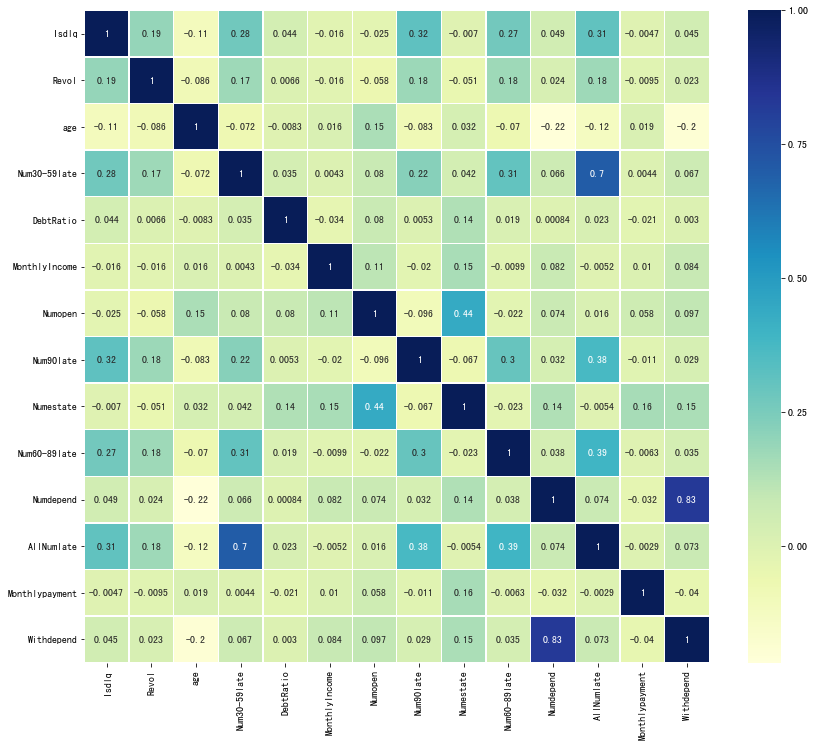

In [77]:
corr=data_train.corr()
plt.figure(figsize=(14,12))
sns.heatmap(corr,annot=True,linewidths=.3,cmap='YlGnBu')

#### 4.3.2 WOE, IV值计算

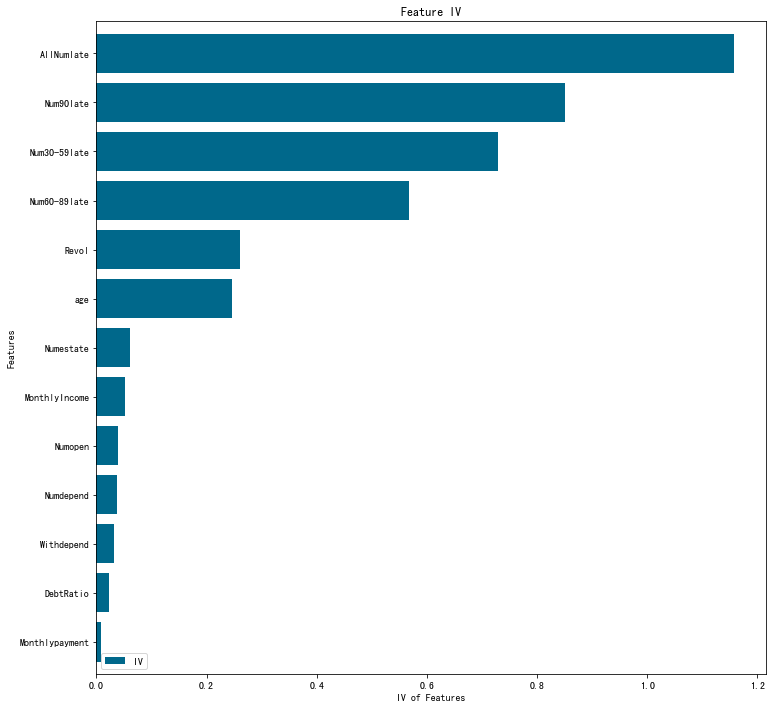

In [242]:
def bin_woe(tar, var, n=None, cat=None):
    """
    连续自变量分箱,woe,iv变换
    tar:target目标变量
    var:进行woe,iv转换的自变量
    n:分组数量
    """
    total_bad = tar.sum()
    total_good =tar.count()-total_bad
    totalRate = total_good/total_bad
    
    if cat == 's':
        msheet = pd.DataFrame({tar.name:tar,var.name:var,'var_bins':pd.qcut(var, n, duplicates='drop')})
        grouped = msheet.groupby(['var_bins'])
    elif (cat == 'd') and (n is None):
        msheet = pd.DataFrame({tar.name:tar,var.name:var})
        grouped = msheet.groupby([var.name])
        
    groupBad = grouped.sum()[tar.name]
    groupTotal = grouped.count()[tar.name]
    groupGood = groupTotal - groupBad
    groupRate = groupGood/groupBad
    groupBadRate = groupBad/groupTotal
    groupGoodRate = groupGood/groupTotal

    woe = np.log(groupRate/totalRate)
    iv = np.sum((groupGood/total_good-groupBad/total_bad)*woe)
    
    if cat == 's':
        new_var, cut = pd.qcut(var, n, duplicates='drop',retbins=True, labels=woe.tolist())
    elif cat == 'd':
        dictmap = {}
        for x in woe.index:
            dictmap[x] = woe[x]
        new_var, cut = var.map(dictmap), woe.index
    
    return woe.tolist(), iv, cut, new_var

# 确定变量类型，连续变量还是离散变量
dvar = ['Revol','DebtRatio','Num30-59late', 'Num60-89late','Num90late','AllNumlate','Withdepend',
        'Numestate','Numdepend']

# 可视化woe得分和iv得分
def woe_vs(data):
    cutdict = {}
    ivdict = {}
    woe_dict = {}
    woe_var = pd.DataFrame()
    for var in data.columns:
        if var in dvar:
            woe, iv, cut, new = bin_woe(data['Isdlq'], data[var], cat='d')
            woe_dict[var] = woe
            woe_var[var] = new
            ivdict[var] = iv
            cutdict[var] = cut
        elif var in svar:
            woe, iv, cut, new = bin_woe(data['Isdlq'], data[var], n=5, cat='s')
            woe_dict[var] = woe
            woe_var[var] = new
            ivdict[var] = iv
            cutdict[var] = cut
            
    ivdict = sorted(ivdict.items(), key=lambda x:x[1], reverse=False)
    iv_vs = pd.DataFrame([x[1] for x in ivdict],index=[x[0] for x in ivdict],columns=['IV'])
    ax = iv_vs.plot(kind='barh',
                    figsize=(12,12),
                    title='Feature IV',
                    fontsize=10,
                    width=0.8,
                    color='#00688B')
    ax.set_ylabel('Features')
    ax.set_xlabel('IV of Features')
    
    return ivdict, woe_var, woe_dict, cutdict

# woe转化
ivinfo, woe_data, woe_dict, cut_dict = woe_vs(data_train)

筛选出IV值大于0.1的变量：'Num30-59late'，'Num60-89late'，'Num90late'，'AllNumlate'，'Revol'，'age'；从以上相关性分析结果看出，'Num30-59late'与'AllNumlate'具有强相关性（0.7），因此两者取IV值较高者'AllNumlate'。

### 4.4 定义（X,y）及交叉验证

In [219]:
from sklearn.model_selection import StratifiedKFold
# 定义 X 和 y
IV_info=['Num60-89late','Num90late','AllNumlate','Revol','age']
X=woe_data[IV_info]
y=data_train['Isdlq']
X = np.array(X.as_matrix())
y = np.array(y.tolist())
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42)


# 检查数据
print X.shape
print X_train.shape
print X_test.shape

(149730, 5)
(112297, 5)
(37433, 5)


## 5. 定义评价指标

### 5.1 混淆矩阵

In [168]:
# 混淆矩阵绘图
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### 5.2 Recall, Precision和F1_score

In [169]:
# 显示评估指标
def show_metrics():
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    print('Precision =     {:.3f}'.format(tp/(tp+fp)))
    print('Recall    =     {:.3f}'.format(tp/(tp+fn)))
    print('F1_score  =     {:.3f}'.format(2*(((tp/(tp+fp))*(tp/(tp+fn)))/
                                                 ((tp/(tp+fp))+(tp/(tp+fn))))))

### 5.3 Precision-Recall曲线

In [170]:
# 绘制 P-R 曲线
def plot_precision_recall():
    plt.step(recall, precision, color = 'b', alpha = 0.2,
             where = 'post')
    plt.fill_between(recall, precision, step ='post', alpha = 0.2,
                 color = 'b')

    plt.plot(recall, precision, linewidth=2)
    plt.xlim([0.0,1])
    plt.ylim([0.0,1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.show();

### 5.4 ROC 曲线

In [198]:
# 绘制 ROC 曲线
def plot_roc():
    plt.plot(fpr, tpr, label = 'AUC = %0.2f'%auc_score, linewidth = 2)
    plt.plot([0,1],[0,1], 'k--', linewidth = 2)
    plt.xlim([0.0,1])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show();

## 6. LogisticRegression: Train (AUC=0.82)

### 6.1 LOG - 未调优超参数

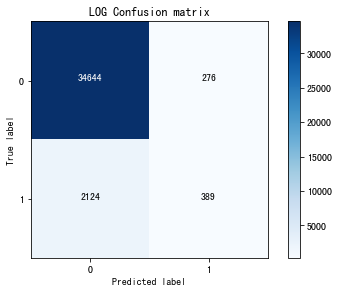

Precision =     0.585
Recall    =     0.155
F1_score  =     0.245


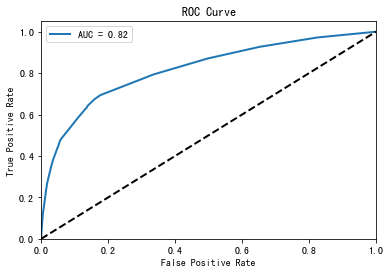

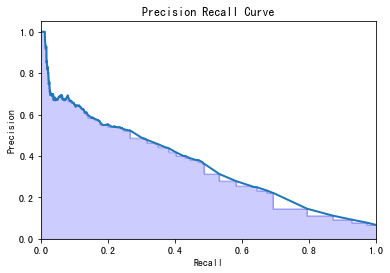

In [199]:
#Logistic模型建立
from sklearn.linear_model import LogisticRegression
# 逻辑斯蒂回归
log_cfl = LogisticRegression()

log_cfl.fit(X_train, y_train)
y_pred = log_cfl.predict(X_test)
y_score = log_cfl.decision_function(X_test)  

# 混淆矩阵 & 评估指标
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes = class_names, 
                      title = 'LOG Confusion matrix')
plt.show()

cm = cm.astype(np.float64)

show_metrics()

# ROC 曲线
fpr, tpr, t = roc_curve(y_test, y_score)
auc_score = roc_auc_score(y_test, y_score)
plot_roc()

# Precision-recall 曲线
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
plot_precision_recall()

In [186]:
# 查看当前参数
from pprint import pprint
print('Parameters currently in use:\n')
pprint(log_cfl.get_params())

Parameters currently in use:

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'warn',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


### 6.2 LOG - GridSearchCV 搜索超参数

In [215]:
# 使用GridSearchCV找到最佳的参数组合
from sklearn.model_selection import GridSearchCV
param_grid = {
            'C' : [0.001, 0.01, 0.1]
            }

CV_log_cfl = GridSearchCV(estimator = log_cfl, param_grid = param_grid , scoring = 'recall', verbose = 1, n_jobs = -1)
CV_log_cfl.fit(X_train, y_train)

best_parameters = CV_log_cfl.best_params_
print('The best parameters for using this model is', best_parameters)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    5.0s finished


('The best parameters for using this model is', {'C': 0.01})


### 6.3 LOG - 超参数更新

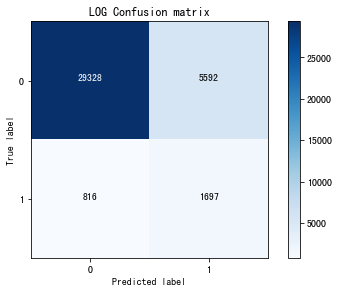

Precision =     0.233
Recall    =     0.675
F1_score  =     0.346


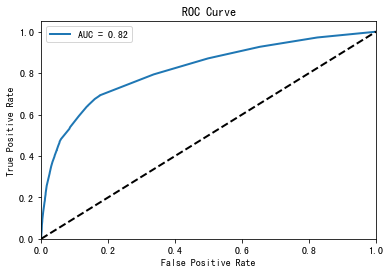

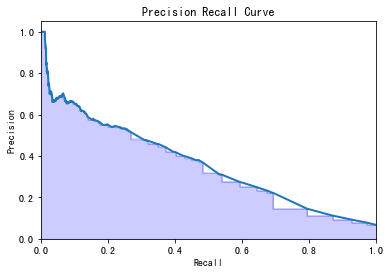

In [273]:
# 使用搜索的超参数组合重新构建模型，将结果可视化
log_cfl = LogisticRegression(C = 0.01, 
                             penalty = 'l2', 
                             class_weight = 'balanced')
log_cfl.fit(X_train, y_train)
y_pred = log_cfl.predict(X_test)
y_score = log_cfl.decision_function(X_test)

# 混淆矩阵 & 评估指标
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title='LOG Confusion matrix')

plt.savefig('log_cfl_confusion_matrix.png')
plt.show()

cm = cm.astype(np.float64)

show_metrics()

# ROC 曲线
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc()

# Precision-recall 曲线
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
plot_precision_recall()

fpr_log, tpr_log, t_log = fpr, tpr, t
precision_log, recall_log, thresholds_log = precision, recall, thresholds

### 6.4 LOG - Precision - Recall - Threshold 曲线

In [274]:
pr = 0.233
rec = 0.675
t = 0.25

# Precision-recall-threshold 曲线 : 
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(16, 12))
    plt.title('Precision and Recall Scores (decision threshold)')
    plt.plot(thresholds, precisions[:-1], 'b-',linewidth=2, label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g', linewidth=2, label='Recall')
    plt.axvline(t, color='k', linestyle='--', label='Threshold')
    plt.axhline(pr, color='blue', linewidth=2, linestyle='--')
    plt.axhline(rec, color='green', linewidth=2, linestyle='--')
    plt.ylabel('Score')
    plt.xlabel('Decision Threshold')
    plt.legend(loc='best')
    plt.savefig('prec_recc_threshold.png')
    plt.show();

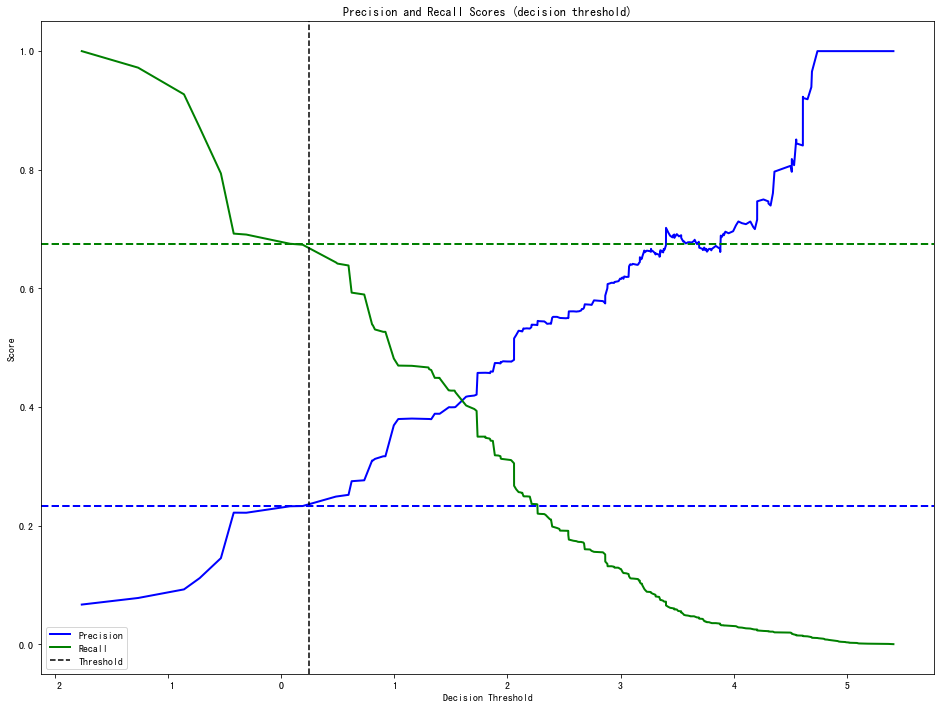

In [275]:
plot_precision_recall_vs_threshold(precision, recall, thresholds)

可见当阈值为0.25时，模型表现最佳。

## 7. 制作评分卡

In [272]:
intercept=model.intercept_
coef=model.coef_
coe=coef[0].tolist()
coe_df=pd.DataFrame({'feature':IV_info,'coe':coe})

import math
B=20/math.log(2)
A=600+B*math.log(1/20)
#基础分
score=round(A-B*intercept[0],0)

featurelist = []
woelist = []
cutlist = []
for k,v in woe_dict.items():
    if k in IV_info:
        for n in range(0,len(v)):
            featurelist.append(k)
            woelist.append(v[n])
            cutlist.append(cut_dict[k][n])
scoreboard = pd.DataFrame({'feature':featurelist,'woe':woelist,'cut':cutlist},
                          columns=['feature','cut','woe'])

score_df=pd.merge(scoreboard,coe_df)
score_df['score']=-B*score_df['woe']*score_df['coe']
score_df['score'] = score_df['score'].round(decimals=0)
score_df.drop('coe',axis=1,inplace=True)
score_df

,feature,cut,woe,score
0,Num60-89late,0.0,0.274309,3.0
1,Num60-89late,1.0,-1.850365,-20.0
2,Num60-89late,2.0,-2.657322,-29.0
3,Num60-89late,3.0,-2.915869,-32.0
4,Num60-89late,4.0,-3.135674,-35.0
5,Num60-89late,5.0,-3.129739,-35.0
6,Num60-89late,6.0,-3.748779,-41.0
7,Num60-89late,7.0,-2.804317,-31.0
8,AllNumlate,0.0,0.923681,17.0
9,AllNumlate,1.0,-1.383442,-25.0
